# Melodia Records - Análise exploratória
Este notebook tem como objetivo apresentar a análise exploratória realizada sobre a base de dados fornecida pela empresa. Ao longo do documento, são descritas e executadas as principais etapas de compreensão, tratamento e visualização dos dados.
## 1- Importando as 3 bases e bibiotecas 

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from ast import literal_eval
db_tracks = pd.read_csv('spotify_tracks.csv')
artistas_df = pd.read_csv('spotify_artists.csv')
db_albuns = pd.read_csv('spotify_albums.csv')

### 1.1- Pré-processamento de db_tracks

In [2]:
#Verificando dados faltantes
db_tracks.isnull().sum()

Unnamed: 0           0
album_id             0
analysis_url         0
artists_id           0
available_markets    0
href                 0
name                 0
playlist             0
popularity           0
preview_url          0
dtype: int64

In [3]:
#Retirando colunas que não são necessárias para a análise
db_tracks_backup = db_tracks
db_tracks.drop(['Unnamed: 0','analysis_url', 'href', 'preview_url'], axis=1, inplace=True)

### 1.2- Pré-processamento de artist_df

In [4]:
#Verificando dados faltantes
artistas_df.isnull().sum()

Unnamed: 0           0
artist_popularity    0
followers            0
genres               0
id                   0
name                 1
track_id             0
track_name_prev      0
type                 0
dtype: int64

In [5]:
# Remover linhas com valores ausentes
artistas_df = artistas_df.dropna()  

In [6]:
#Retirando colunas que não são necessárias para a análise
artistas_df = artistas_df.drop('Unnamed: 0', axis=1)  
artistas_df = artistas_df.drop('type', axis=1)

In [7]:
(artistas_df['genres'] == '[]').sum() # Verifica se há gêneros vazios

np.int64(23539)

Nota-se a presença de uma quantidade elevada de gêneros vazios. Essa coluna será completada futuramente após o merge das 3 bases de dados

### 1.3- Pré-processamento de db_albuns

In [8]:
#Verificando dados faltantes
db_albuns.isnull().sum() 

Unnamed: 0                0
album_type                0
artist_id                 0
available_markets         0
external_urls             0
href                      0
id                        0
images                    0
name                      0
release_date              0
release_date_precision    0
total_tracks              0
track_id                  0
track_name_prev           0
uri                       0
type                      0
dtype: int64

In [9]:
#Retirando colunas que não são necessárias para a análise
db_albuns.drop(['Unnamed: 0','href', 'external_urls', 'images', 'uri'], axis=1, inplace=True)

## 2- Merge das 3 bases de dados

In [10]:
cols_drop_albuns = ['Unnamed: 0', 'external_urls', 'href', 'uri', 'type', 'available_markets', 'images', 'track_name_prev']
cols_drop_artists = ['Unnamed: 0', 'type', 'track_id', 'track_name_prev']
cols_drop_tracks = ['Unnamed: 0', 'analysis_url', 'href', 'available_markets', 'preview_url']

db_albuns = db_albuns.drop(columns=cols_drop_albuns, errors='ignore')
db_artists = artistas_df.drop(columns=cols_drop_artists, errors='ignore')
db_tracks = db_tracks.drop(columns=cols_drop_tracks, errors='ignore')

merge1 = pd.merge(db_albuns, db_artists, left_on='artist_id', right_on='id', how='inner')

db_final = pd.merge(merge1, db_tracks, left_on='id_x', right_on='album_id', how='inner')

db_final.drop(columns=['id_x', 'name_x', 'id_y', 'artists_id'], inplace=True)

db_final = db_final.drop_duplicates(subset=db_final.columns[1:])

db_final.head()


,album_type,artist_id,release_date,release_date_precision,total_tracks,track_id,artist_popularity,followers,genres,name_y,album_id,name,playlist,popularity
0,single,3DiDSECUqqY1AuBP8qtaIa,2019-02-08,day,6,2iejTMy9XZ8Gaae0aQ2yl0,79,5946074,"['hip pop', 'neo soul', 'pop', 'r&b', 'urban c...",Alicia Keys,1gAM7M4rBwEbSPeAQR2nx1,If I Ain't Got You - Radio Edit,Chillout Session,41.0
1,album,6s1pCNXcbdtQJlsnM1hRIA,2019-03-01,day,8,1WQfghEjszJJ4H8MAWrQ2C,57,135831,"['classical', 'compositional ambient', 'russia...",Dmitri Shostakovich,4KfJZV7WfolYlxBzOTo66s,"Symphony No. 5 in D Minor, Op. 48: II Allegretto",Classical New Releases: Spotify Picks,37.0
2,single,5YjfNaHq05WrwldRe1QSBc,2019-03-14,day,1,3jJKj4QTK3v18ZSwpk7AcV,18,118,[],Brandon Mints,7nLYY7uAVUb57kpd7tZxnS,Take My Bass,Bangers,4.0
3,single,2G9Vc16JCpnZmK4uGH46Fa,2016-11-16,day,1,1xGtDafUZbHyYC3Xarcbrj,24,309,[],DØ CHEF DØ,6p20Rt4x2Qn5mUMRi1s6pj,Hypnotizing (Are U),Smukfest 2019,27.0
4,single,2dwM9OcE4c3Ph1UBINSodx,2018-07-20,day,1,0gWtsXvXOzAT6FtM3ur8in,24,1394,[],Alejo García,1XeoOqC1q7U2iyLEQJ64cu,Sunshine,Nuevo Macondo,30.0


### 2.1- Completar gêneros faltantes

Durante a análise, foi identificada a presença de valores ausentes na coluna de gêneros. Para preservar a consistência da base de dados, foi aplicada uma estratégia para imputação desses valores.

A abordagem adotada consistiu em, para cada linha com registros de gêneros nulos, buscar outras entradas correspondentes ao mesmo artista / album / data de lançamento que já continham informações válidas de gênero. Essas informações existentes foram então replicadas de forma coerente para as linhas em que o gênero se encontrava ausente.

In [11]:
db_final['genres'] = db_final['genres'].apply(lambda x: np.nan if x == '[]' else x)

db_final['genres'] = db_final.groupby('album_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('name_y')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('name')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('artist_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

db_final['genres'] = db_final.groupby('playlist')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_1931/3040319660.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  db_final['genres'] = db_final.groupby('album_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_1931/3040319660.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  db_final['genres'] = db_final.groupby('album_id')['genres'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_1931/3040319660.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use o

In [12]:
print(db_final['genres'].isna().sum())

304


## 3- Gráficos e insights


### 3.1 - Quantidade de albuns por década e por ano

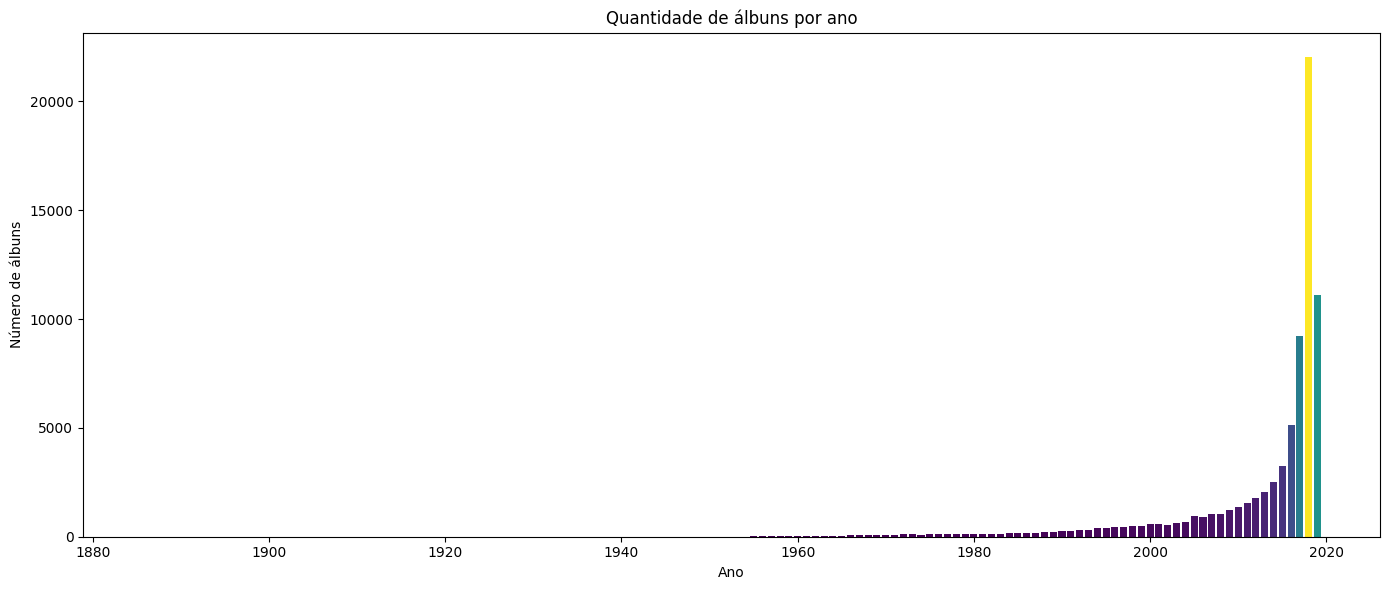

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter datas para ano
db_albuns['release_date'] = pd.to_datetime(db_albuns['release_date'], format='mixed', errors='coerce').dt.year
db_albuns = db_albuns.dropna(subset=['release_date'])
db_albuns['release_date'] = db_albuns['release_date'].astype(int)

# Contar quantidade de álbuns por ano
albuns_por_ano = db_albuns['release_date'].value_counts().sort_index()

# Plotar gráfico colorido
plt.figure(figsize=(14,6))
colors = plt.cm.viridis((albuns_por_ano - albuns_por_ano.min()) / (albuns_por_ano.max() - albuns_por_ano.min()))
plt.bar(albuns_por_ano.index, albuns_por_ano.values, color=colors)

plt.title('Quantidade de álbuns por ano')
plt.xlabel('Ano')
plt.ylabel('Número de álbuns')
plt.tight_layout()
plt.show()


### 3.2 - Quantidade de album, single e compilation

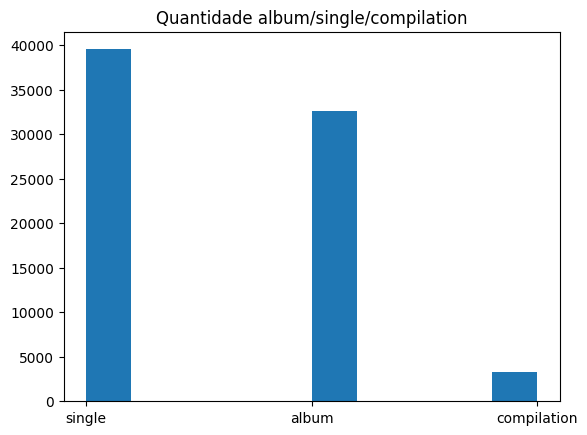

In [14]:
plt.hist(db_albuns['album_type'])
plt.title('Quantidade album/single/compilation')
plt.show()

### 3.3 - Distribuição da popularidade de artista

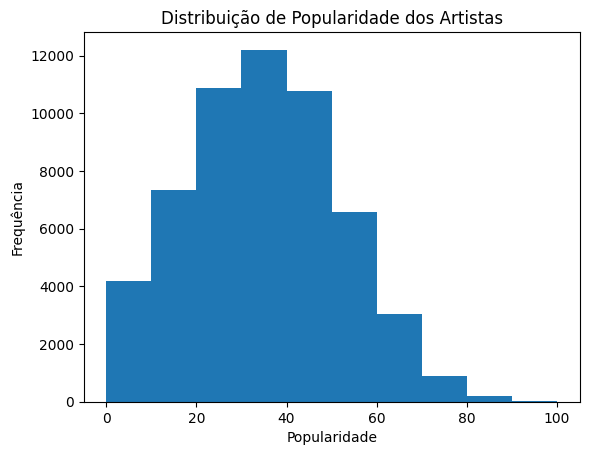

In [15]:
plt.hist(artistas_df['artist_popularity'])
plt.title('Distribuição de Popularidade dos Artistas')
plt.xlabel('Popularidade') 
plt.ylabel('Frequência')
plt.show()

### 3.4 - Distribuição da popularidade de música

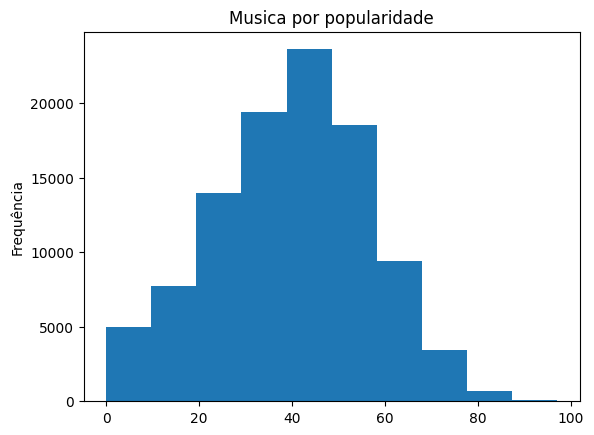

In [16]:
plt.hist(db_tracks['popularity'])
plt.title('Musica por popularidade')
plt.ylabel('Frequência')
plt.show()

### 3.5 - Popularidade por tipo de lançamento

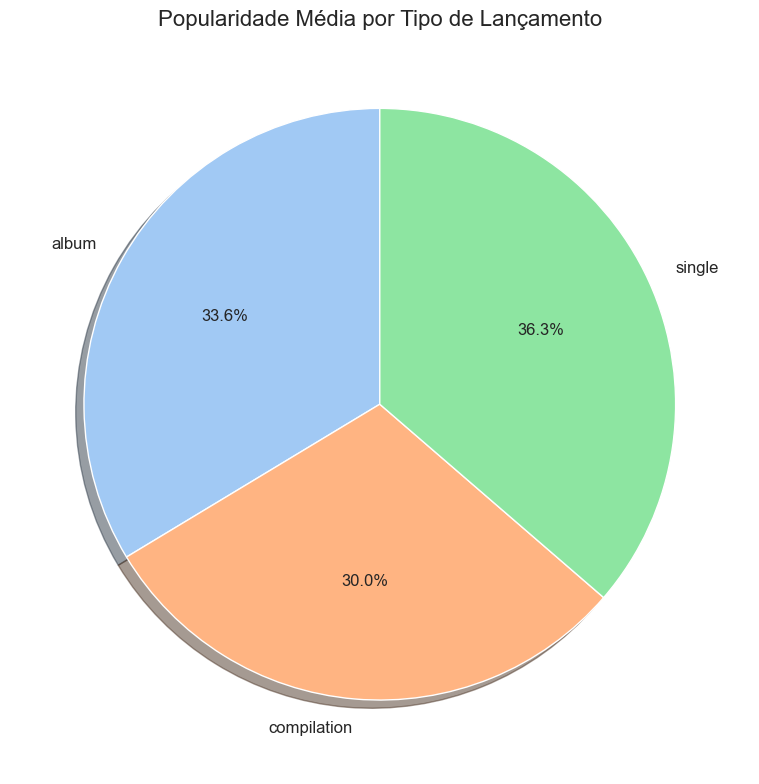

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


popularidade_por_album_type = db_final.groupby('album_type')['popularity'].mean().dropna()


colors = sns.color_palette('pastel')[0:len(popularidade_por_album_type)]


plt.figure(figsize=(8, 8))
plt.pie(
    popularidade_por_album_type,
    labels=popularidade_por_album_type.index,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    colors=colors,
    textprops={'fontsize': 12}
)


plt.title('Popularidade Média por Tipo de Lançamento', fontsize=16)
plt.ylabel('')  

plt.tight_layout()
plt.show()


### 3.6 - Popularidade de artista por seguidores

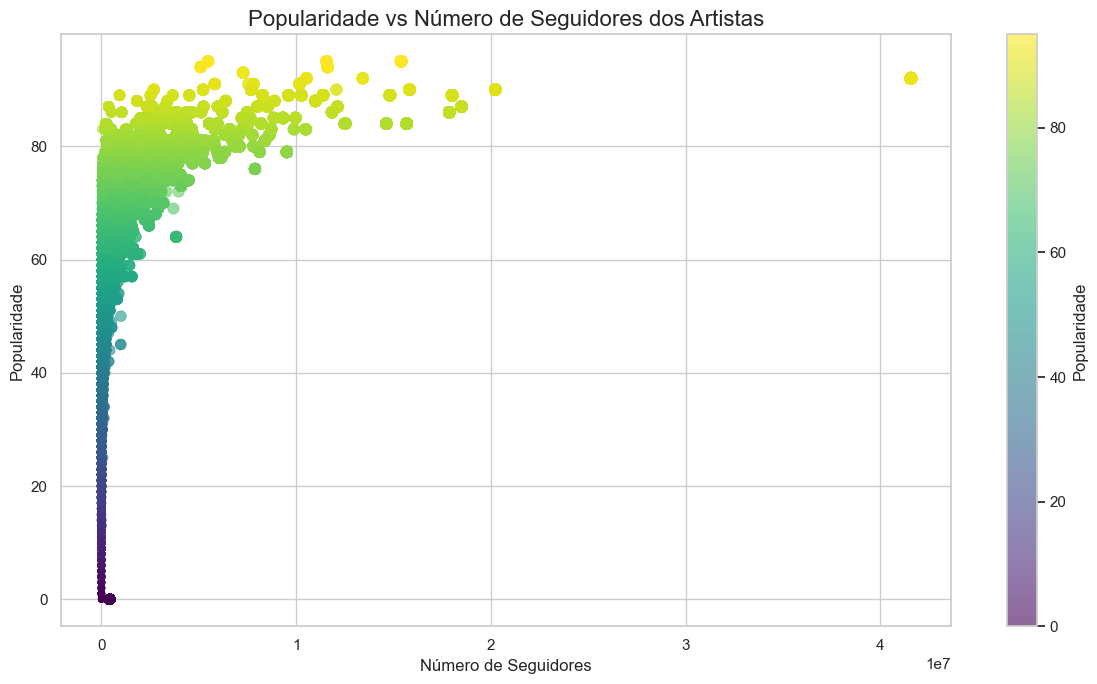

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


sns.set(style='whitegrid')


tamanho_pontos = np.log10(db_final['followers'] + 1) * 10  


cores = db_final['artist_popularity']

plt.figure(figsize=(12, 7))
scatter = plt.scatter(
    db_final['followers'],
    db_final['artist_popularity'],
    c=cores,
    cmap='viridis',
    s=tamanho_pontos,
    alpha=0.6,
    linewidth=0.5
)

plt.colorbar(scatter, label='Popularidade')  # legenda para cor
plt.title('Popularidade vs Número de Seguidores dos Artistas', fontsize=16)
plt.xlabel('Número de Seguidores', fontsize=12)
plt.ylabel('Popularidade', fontsize=12)



plt.tight_layout()
plt.show()


### 3.7 - Popularidade por gênero

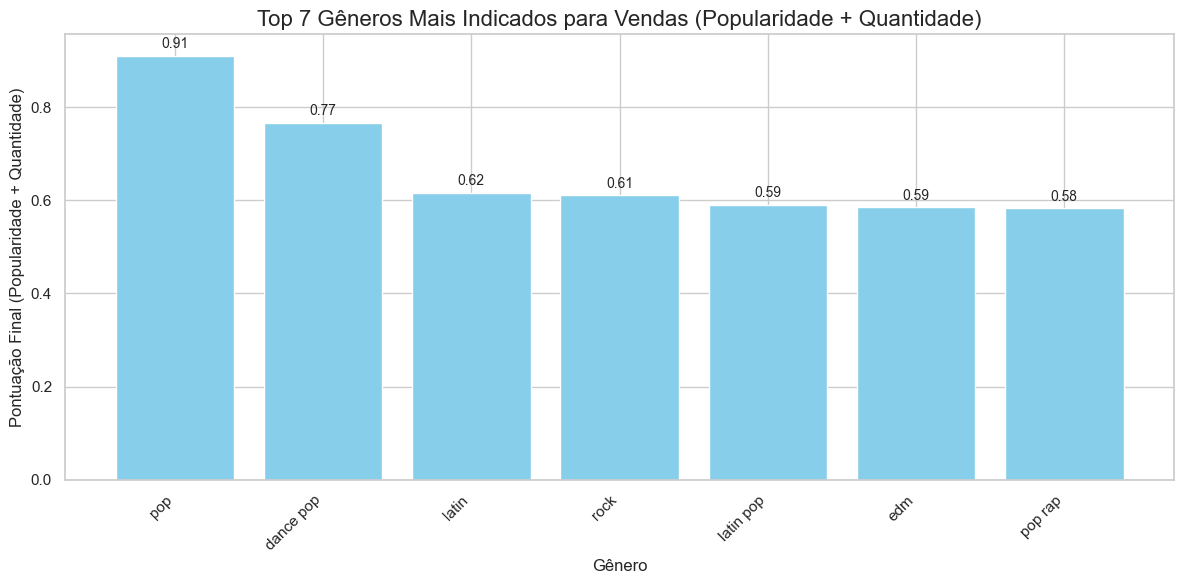

In [19]:
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt

# Garante que a coluna genres seja lista
db_final['genres'] = db_final['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Dicionários para somar popularidade e contar quantas vezes o gênero aparece
genero_popularidade_total = {}
genero_contagem = {}

for _, row in db_final.iterrows():
    generos = row['genres']
    peso = row['popularity']
    
    if not isinstance(generos, list) or pd.isna(peso):
        continue
    
    for genero in generos:
        genero_popularidade_total[genero] = genero_popularidade_total.get(genero, 0) + peso
        genero_contagem[genero] = genero_contagem.get(genero, 0) + 1

# Calcula a média de popularidade por gênero
genero_media = {g: genero_popularidade_total[g] / genero_contagem[g] for g in genero_popularidade_total}

# Cria DataFrame com os dados
df_generos = pd.DataFrame({
    'Gênero': list(genero_media.keys()),
    'Popularidade Média': list(genero_media.values()),
    'Quantidade': [genero_contagem[g] for g in genero_media.keys()]
})

# Normalização manual (Min-Max)
def normalizar(coluna):
    min_val = coluna.min()
    max_val = coluna.max()
    return (coluna - min_val) / (max_val - min_val) if max_val != min_val else coluna

df_generos['pop_norm'] = normalizar(df_generos['Popularidade Média'])
df_generos['qtd_norm'] = normalizar(df_generos['Quantidade'])

# Cria uma pontuação final combinando popularidade e quantidade (peso igual)
df_generos['pontuacao_final'] = (df_generos['pop_norm'] + df_generos['qtd_norm']) / 2

# Seleciona os 7 gêneros com maior pontuação final
df_top10 = df_generos.sort_values(by='pontuacao_final', ascending=False).head(7)

# Cria o gráfico de barras
plt.figure(figsize=(12, 6))
bars = plt.bar(df_top10['Gênero'], df_top10['pontuacao_final'], color='skyblue')

# Adiciona valores em cima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Top 7 Gêneros Mais Indicados para Vendas (Popularidade + Quantidade)', fontsize=16)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Pontuação Final (Popularidade + Quantidade)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 3.8 - Popularidade por tempo

Nesse gráfico é possível que as músicas atuais tendem a ser mais populares

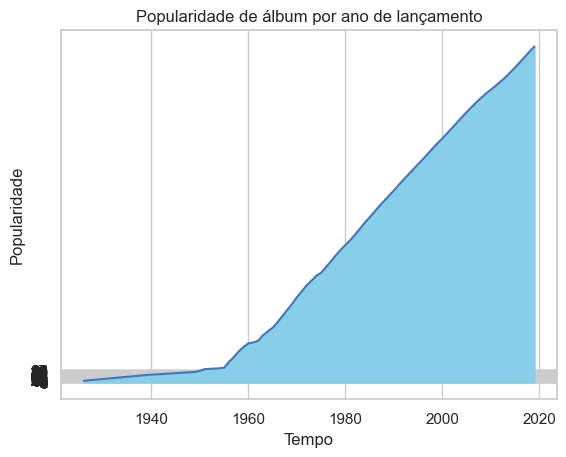

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

db_final['release_date'] = pd.to_datetime(db_final['release_date'], errors='coerce')
db_final['release_year'] = db_final['release_date'].dt.year

popularidade_por_ano = db_final.groupby('release_year')['popularity'].mean().dropna()
pop_acumulada = popularidade_por_ano.cumsum()

# Plotando
pop_acumulada.plot(kind='line')
plt.fill_between(pop_acumulada.index, pop_acumulada.values, color='skyblue')
plt.ylabel('Popularidade')
plt.xlabel('Tempo')
plt.title('Popularidade de álbum por ano de lançamento')

# Aqui você define os valores que deseja no eixo Y
plt.yticks(np.arange(0, 100))

plt.show()


### 3.9 - Quantidade de faixas por popularidade

Nesse gráfico é possível ver que conforme a popularidade aumenta, o numero total de faixas por álbum diminui, então priorizar albuns com números menores de faixas faz sentido pela questão de sua popularidade

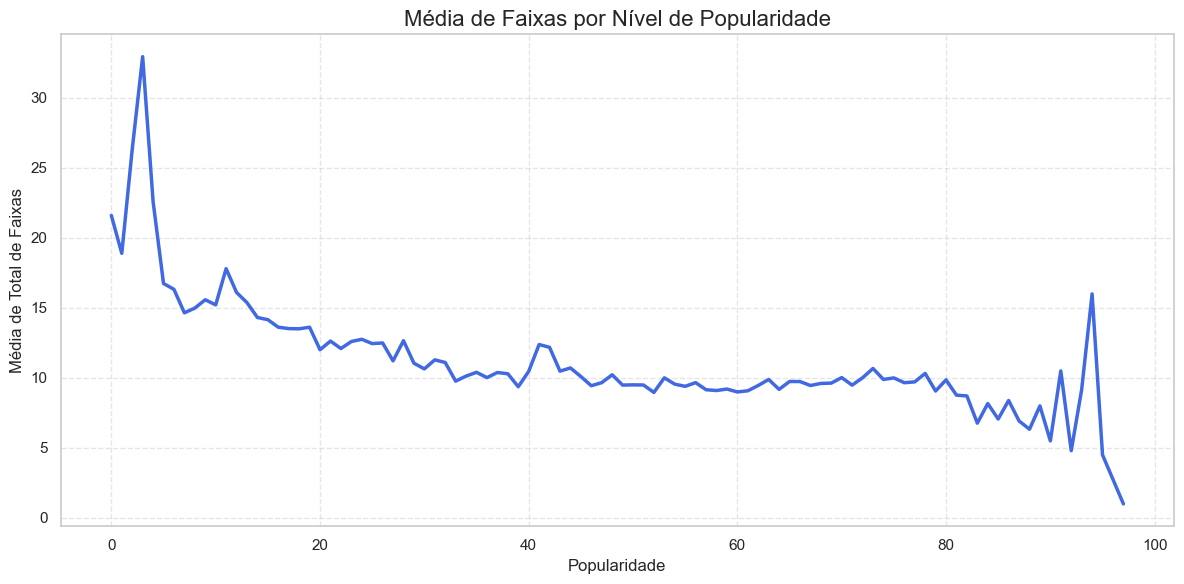

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')


popularidade_por_qtd = db_final.groupby('popularity')['total_tracks'].mean().dropna()


plt.figure(figsize=(12, 6))
sns.lineplot(
    x=popularidade_por_qtd.index,
    y=popularidade_por_qtd.values,
    color='royalblue',
    linewidth=2.5,

)

plt.title('Média de Faixas por Nível de Popularidade', fontsize=16)
plt.xlabel('Popularidade', fontsize=12)
plt.ylabel('Média de Total de Faixas', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [22]:
pop_artistas = db_final[db_final['genres'].apply(lambda x: isinstance(x, list) and 'pop' in [g.lower() for g in x])]
dance_pop_artistas = db_final[db_final['genres'].apply(lambda x: isinstance(x, list) and 'dance pop' in [g.lower() for g in x])]
latin_artistas = db_final[db_final['genres'].apply(lambda x: isinstance(x, list) and 'latin' in [g.lower() for g in x])]

pop_ranking = pop_artistas.groupby('name_y')['artist_popularity'].mean().sort_values(ascending=True)
dancepop_ranking = dance_pop_artistas.groupby('name_y')['artist_popularity'].mean().sort_values(ascending=True)
latin_ranking = latin_artistas.groupby('name_y')['artist_popularity'].mean().sort_values(ascending=True)


### 3.10 - Top 10 Artistas de Pop

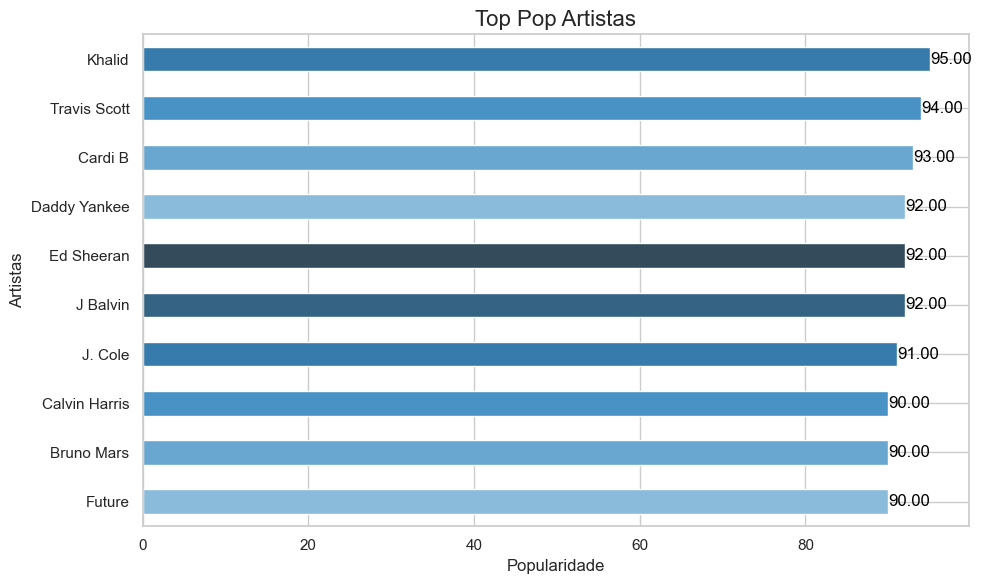

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')


plt.figure(figsize=(10, 6))
ax = pop_ranking.tail(10).plot(kind='barh', color=sns.color_palette('Blues_d'))


plt.title('Top Pop Artistas', fontsize=16)
plt.xlabel('Popularidade', fontsize=12)
plt.ylabel('Artistas', fontsize=12)


for i, v in enumerate(pop_ranking.tail(10).values):
    ax.text(v + 0.02, i, f'{v:.2f}', color='black', va='center', fontsize=12)


plt.tight_layout()
plt.show()


### 3.11 - Top 10 Artistas de Dance Pop

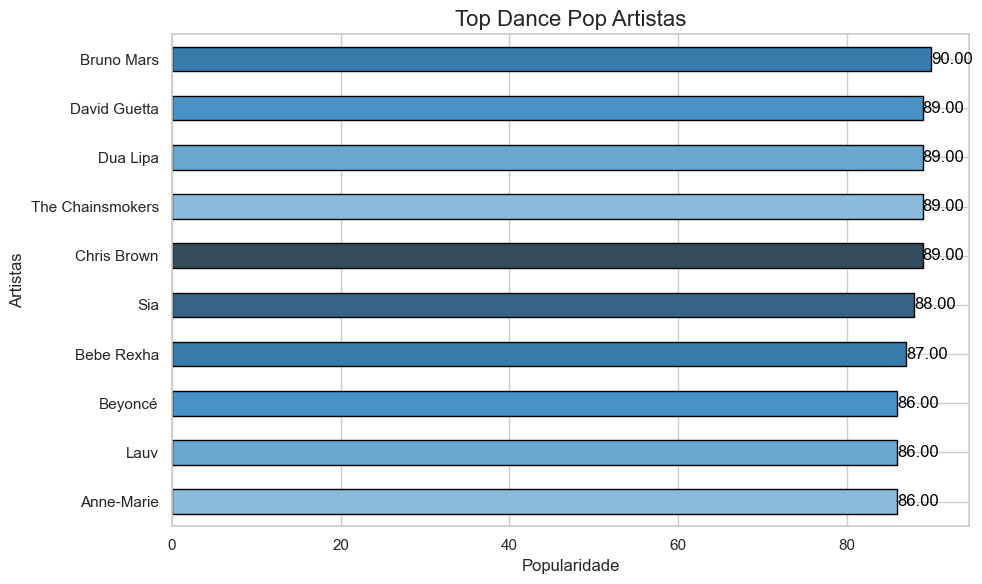

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')


plt.figure(figsize=(10, 6))
ax = dancepop_ranking.tail(10).plot(kind='barh', color=sns.color_palette('Blues_d'), edgecolor='black')


plt.title('Top Dance Pop Artistas', fontsize=16)
plt.xlabel('Popularidade', fontsize=12)
plt.ylabel('Artistas', fontsize=12)


for i, v in enumerate(dancepop_ranking.tail(10).values):
    ax.text(v + 0.02, i, f'{v:.2f}', color='black', va='center', fontsize=12)


plt.tight_layout()
plt.show()


### 3.12 - Top 10 Artistas de Latino

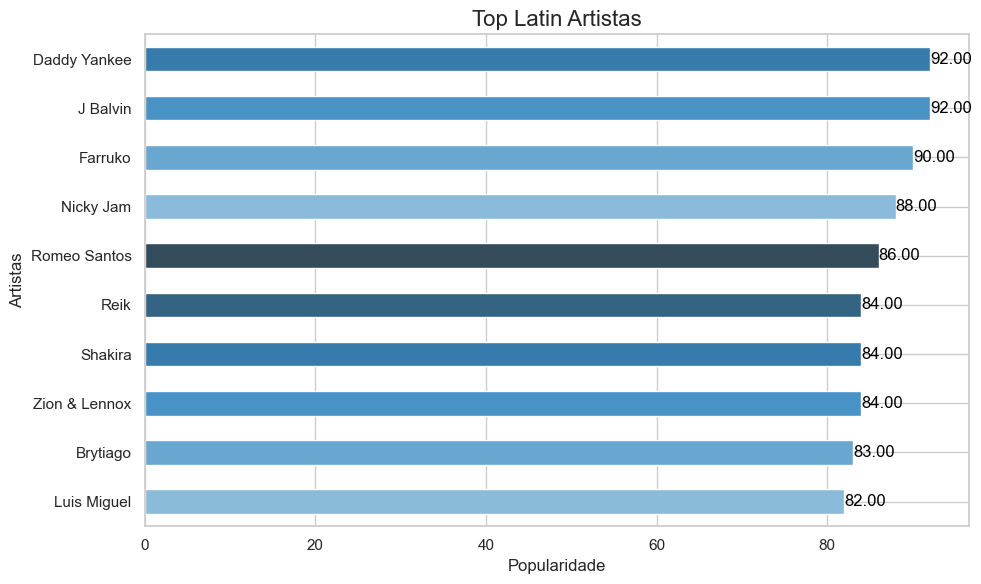

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid')


plt.figure(figsize=(10, 6))
ax = latin_ranking.tail(10).plot(kind='barh', color=sns.color_palette('Blues_d'))


plt.title('Top Latin Artistas', fontsize=16)
plt.xlabel('Popularidade', fontsize=12)
plt.ylabel('Artistas', fontsize=12)


for i, v in enumerate(latin_ranking.tail(10).values):
    ax.text(v + 0.02, i, f'{v:.2f}', color='black', va='center', fontsize=12)


plt.tight_layout()
plt.show()


### 3.13 - Top 10 Artistas mais seguidos

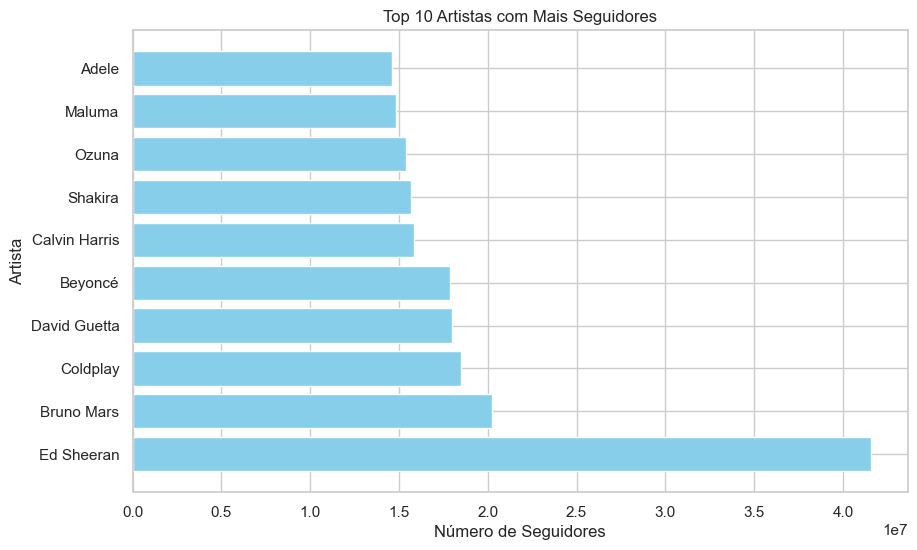

In [26]:
import matplotlib.pyplot as plt


unique_artistas = db_final.drop_duplicates(subset='name_y')
top_10_artistas = unique_artistas.sort_values('followers', ascending=False).head(10)


plt.figure(figsize=(10, 6))
plt.barh(top_10_artistas['name_y'], top_10_artistas['followers'], color='skyblue')


plt.title('Top 10 Artistas com Mais Seguidores')
plt.xlabel('Número de Seguidores')
plt.ylabel('Artista')


plt.show()


### 3.14 - Playlists mais populares

/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_1931/2220749386.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


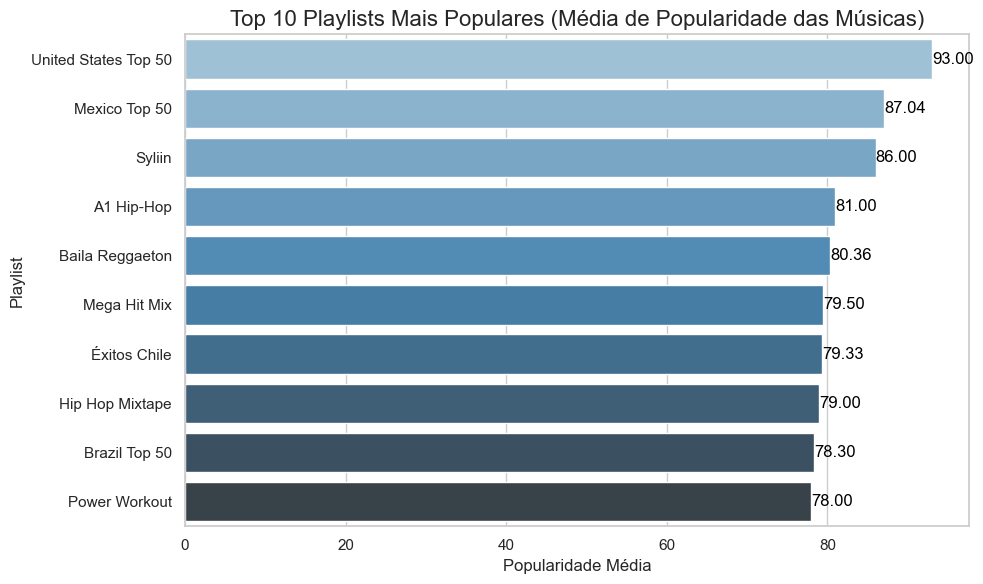

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


album_popularity = db_final.groupby('playlist')['popularity'].mean().reset_index()


top_albuns = album_popularity.sort_values('popularity', ascending=False).head(10)


sns.set(style='whitegrid')


plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='popularity', 
    y='playlist', 
    data=top_albuns, 
    palette='Blues_d', 
    orient='h'
)


plt.title('Top 10 Playlists Mais Populares (Média de Popularidade das Músicas)', fontsize=16)
plt.xlabel('Popularidade Média', fontsize=12)
plt.ylabel('Playlist', fontsize=12)


for i, v in enumerate(top_albuns['popularity']):
    ax.text(v + 0.02, i, f'{v:.2f}', color='black', va='center', fontsize=12)


plt.tight_layout()


plt.show()


### 3.15 - Artistas ideais para vendas

Esta análise foi realizada com o objetivo de identificar quais artistas têm o maior potencial para vender CDs, considerando dois fatores cruciais: popularidade e número de seguidores. A premissa por trás dessa análise é que deve-se focar em artistas que não apenas sejam populares no momento, mas que também possuam uma base fiel de fãs.
As duas variáveis (popularidade e seguidores) foram normalizadas utilizando a técnica de MinMaxScaler para que ficassem na mesma escala de 0 a 1. Isso permite que ambas as métricas sejam comparadas de forma justa, sem que uma sobreponha a outra devido às suas escalas diferentes.
Para identificar os artistas com maior potencial de vendas, foi criada uma pontuação combinada (chamada final_score). Essa pontuação leva em consideração a média da popularidade e a média dos seguidores. Ou seja, a análise não apenas favorece artistas populares no momento, mas também dá peso aos artistas com bases de fãs grandes e fiéis.



/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_1931/975054379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dance_pop_artistas['pop_norm'] = (
/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_1931/975054379.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dance_pop_artistas['followers_norm'] = (
/var/folders/_l/4nhps33j6z54025qpbx1zqh40000gn/T/ipykernel_1931/975054379.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

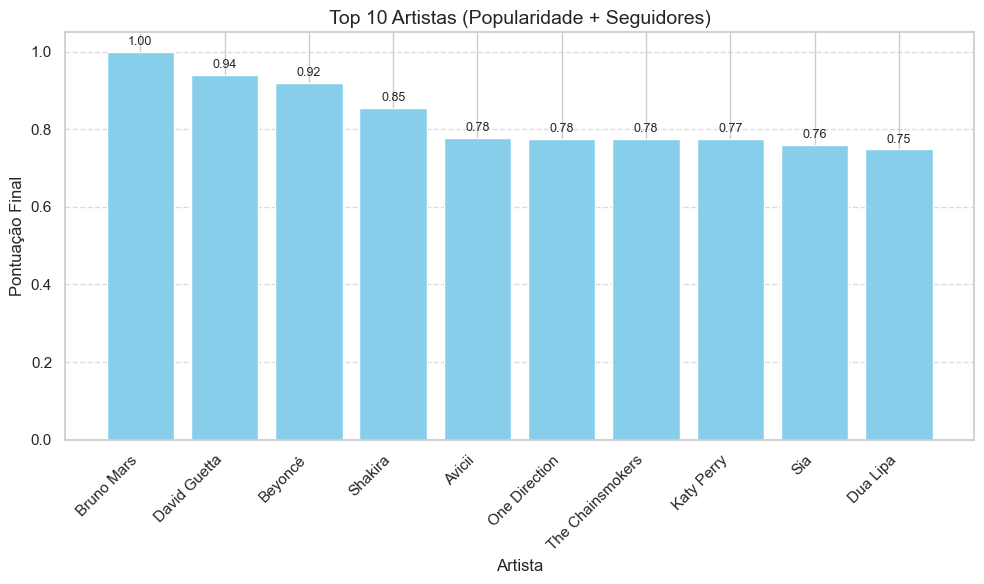

In [28]:
import pandas as pd
import matplotlib.pyplot as plt




dance_pop_artistas['pop_norm'] = (
    (dance_pop_artistas['artist_popularity'] - dance_pop_artistas['artist_popularity'].min()) /
    (dance_pop_artistas['artist_popularity'].max() - dance_pop_artistas['artist_popularity'].min())
)

dance_pop_artistas['followers_norm'] = (
    (dance_pop_artistas['followers'] - dance_pop_artistas['followers'].min()) /
    (dance_pop_artistas['followers'].max() - dance_pop_artistas['followers'].min())
)


dance_pop_artistas['final_score'] = (
    dance_pop_artistas['pop_norm'] + dance_pop_artistas['followers_norm']
) / 2


ranking_final = dance_pop_artistas.groupby('name_y')['final_score'].mean().reset_index()
ranking_final = ranking_final.sort_values(by='final_score', ascending=False).head(10)


plt.figure(figsize=(10, 6))
bars = plt.bar(ranking_final['name_y'], ranking_final['final_score'], color='skyblue')
plt.title('Top 10 Artistas (Popularidade + Seguidores)', fontsize=14)
plt.xlabel('Artista')
plt.ylabel('Pontuação Final')
plt.xticks(rotation=45, ha='right')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## 3.16 Artistas com potencial futuro

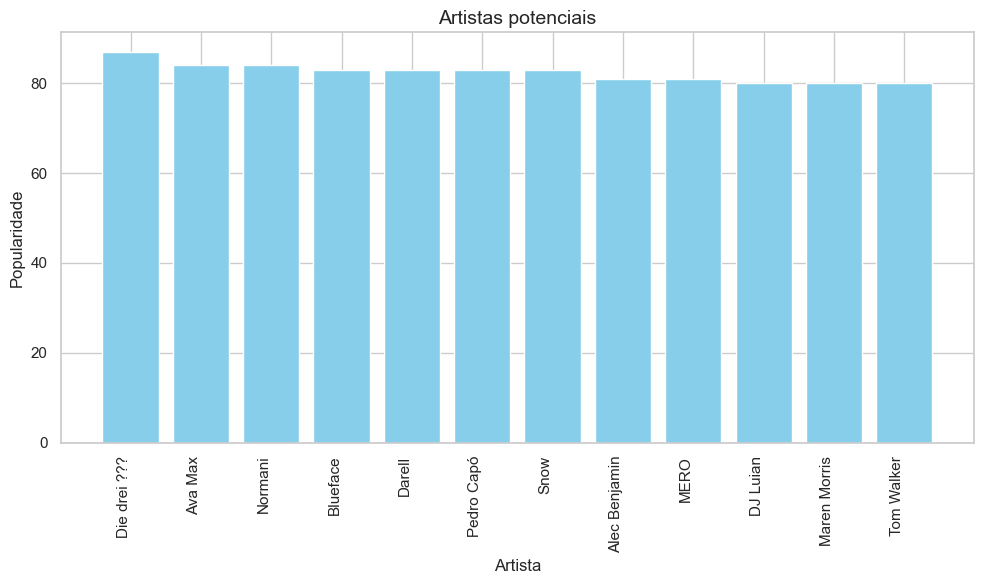

In [29]:
artistas_pot = db_final[(db_final['followers'] <= 500000) & (db_final['artist_popularity'] >= 80)]


artistas_pot_agrupados = artistas_pot.groupby('name_y')['artist_popularity'].mean().reset_index()

artistas_pot_agrupados = artistas_pot_agrupados.sort_values(by='artist_popularity', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(artistas_pot_agrupados['name_y'], artistas_pot_agrupados['artist_popularity'], color='skyblue')


plt.title('Artistas potenciais', fontsize=14)
plt.xlabel('Artista', fontsize=12)
plt.ylabel('Popularidade', fontsize=12)
plt.xticks(rotation=90, ha='right')  


plt.tight_layout()
plt.show()